In [1]:
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregseq

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In this notebook, we will simulate a synthetic dataset for a gene with the simple repression regulatory architecture. We choose the lacZYA promoter, which contains the LacI O1 binding site. The energy matrix for RNAP has been previously determined by [Brewster et al.](https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002) and the energy matrix for lacI has been determined in Barnes et al.


## 0. Loading input data

### regulatory sequence

Given the genomic sequence of *E. coli* and the known TSS of lacZ, we load the sequence of the lacZYA promoter assuming that the length of the promoter is 160bp.

In [2]:
_genome = []
for record in SeqIO.parse("../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
## Find the transcription start site
df = pd.read_csv('../data/ecoli_gene_list.csv')
lacO1_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
lacO1_TSS

366343

In [4]:
lacO1 = tregseq.seq_utils.get_regulatory_region(genome, lacO1_TSS, reverse=True)
lacO1

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [5]:
# Promoter
lacWT = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequences
O1 = 'AATTGTGAGCGGATAACAATT'

In [6]:
lacO1.find(lacWT)

74

In [7]:
lacO1.find(O1)

115

### energy matrices

Now we load the experimentally determined energy matrices. We "fix" the matrices such that the binding energy corresponding to the wild type base identity at each position is 0. This makes sense because when we calculate $p_{\mathrm{bound}}$ and fold change, the relevant parameter is $\Delta \varepsilon$.

In [8]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

#rnap_emat_raw = np.loadtxt('../data/energy_matrices/RNAP_energy_matrix.txt')
#rnap_emat = tregseq.simulate.fix_wt(rnap_emat_raw, lacWT)

rnap_emat = np.loadtxt('../data/energy_matrices/RNAP_energy_matrix.txt')

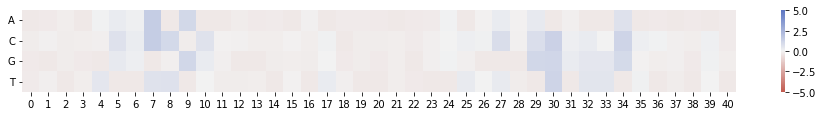

In [9]:
div_colors = sns.diverging_palette(16, 258, s=56, l=51, n=15, sep=2, center='light', as_cmap=True)

fig, ax = plt.subplots(figsize=(16, 1.5))
sns.heatmap(rnap_emat.T, cmap=div_colors, ax=ax, vmin=-5, vmax=5)
ax.set_yticklabels(['A', 'C', 'G', 'T'], rotation=360)
plt.show()

In [10]:
O1_1027_raw = np.load('../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregseq.simulate.fix_wt(O1_1027_raw[i], O1)

O1_emat = np.mean(O1_1027_fixed, axis=0)
#O1_emat = np.mean(O1_1027_raw, axis=0)

In [27]:
tregseq.simulate.get_d_energy(O1, np.mean(O1_1027_raw, axis=0))

-35.29624206907399

In [11]:
# Set up dictionaries that can be used to make a dataframe for all predictions and measurements
# energy_dict = {'O1' : -15.3, 'O2' : -13.9, 'O3' : -9.7}

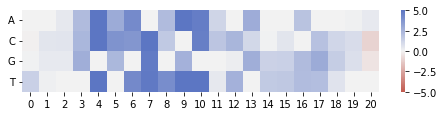

In [12]:
fig, ax = plt.subplots(figsize=(8, 1.5))

sns.heatmap(O1_emat.T, cmap=div_colors, ax=ax, vmin=-5, vmax=5)
ax.set_yticklabels(['A', 'C', 'G', 'T'], rotation=360)
plt.show()

## 1. Generate promoter variants

We generate promoter variants by making random mutations based on the wild type regulatory sequence. We use $10^4$ promoter variants (which is quite large) for now but need to potentially test the minimum number of promoter variants required for a nice-looking information footprint.

In [13]:
lacO1_mutants = np.unique(tregseq.wgregseq.mutations_rand(lacO1, rate=0.1, num_mutants=10000, number_fixed=True))

## 2. Calculate $p_{\mathrm{bound}}$

Now we have everything we need to calculate the probability of RNAP binding for each promoter variant. For a gene with the simple repression regulatory architecture, we can express the probablity of binding (show derivation in manuscript) as
$$
p_{\mathrm{bound}} = \frac{\frac{P}{N_{NS}}e^{-\beta \Delta \varepsilon_P}}{1 + \frac{P}{N_{NS}}e^{-\beta \Delta \varepsilon_P} + \frac{R}{N_{NS}}e^{-\beta \Delta \varepsilon_R}}.
$$
As we can see, the parameters that we need are the number of RNAPs ($P$), the number of repressors ($R$), the number of non-specific binding sites ($N_{NS}$), and the binding energies for RNAP and lacI ($\Delta \varepsilon_P$ and $\Delta \varepsilon_R$).

The data for $P$ and $R$ can be readily found on BioNumbers. Assuming that every site in the genome can be a non-specific binding site, we can approximate $N_{NS}$ as the length of the genome.

In [14]:
n_NS = len(genome)

n_p = 4600 #[BNID: 108601]

# [BNID: 100734]
n_r = 10 # 0.01 * 10**(-6) M (mol / m3) * 10^(-18) m^3 * 6 * 10**23 mol-1; doesn't really match tho

Next, for each promoter variant, we calculate the energy of binding of the RNAP and lacI by mapping the mutant sequences to the energy matrices. Finally, we can plug in the values for all the parameters into the expression above to calculate $p_{\mathrm{bound}}$.

In [15]:
lac_start, lac_end = tregseq.seq_utils.find_binding_site(lacO1, lacWT)
O1_start, O1_end = tregseq.seq_utils.find_binding_site(lacO1, O1)

print('The RNAP binding site is from {} to {}'.format(lac_start - 115, lac_end - 115))
print('The repressor binding site is from {} to {}'.format(O1_start - 115, O1_end - 115))

The RNAP binding site is from -41 to 0
The repressor binding site is from 0 to 21


In [16]:
l_tr = []
for mut in lacO1_mutants:
    rv = {}
    rv['seq'] = mut
    psite_mut = mut[lac_start:lac_end].upper()
    O1_mut = mut[O1_start:O1_end].upper()
    rv['pbound'] = tregseq.simulate.simrep_pbound(psite_mut, O1_mut, rnap_emat, O1_emat, n_p, n_r, n_NS,
                                                  er_wt=-15.3)
    l_tr.append(rv)

In [17]:
df_tr = pd.DataFrame.from_records(l_tr)
df_tr.head()

,seq,pbound
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.068739
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.022009
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.019749
3,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.013469
4,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.010024


## 3. Generate sequence counts

Now, in order to produce a dataset that has the same structure as the dataset that we would obtain experimentally by performing RNA sequencing, we need map the values for $p_\mathrm{bound}$ to RNA counts.

We first rely on the occupancy hypothesis, which states that the rate of mRNA production is proportion to the probability of RNA polymerase occupany at the promoter (from Figure 1 theory paper). This means that
$$
\frac{dm}{dt} = r p_{\mathrm{bound}} - \gamma m,
$$
where $m$ is the number of mRNAs, $r$ is the rate of transcription, and $\gamma$ is the rate of degradation. 
Therefore, at steady state,
$$
m^* = \frac{r}{\gamma} p_{\mathrm{bound}}.
$$

In this case we assume that the rate of transcription is proportional to the number of copies of DNA in the system (this could be the copy of plasmids or the copy of genes in the chromosomal, in the case where we perform chromosomal integration). Hence we re-write the above equation as
$$
m^* = \frac{r'}{\gamma} c_{\mathrm{DNA}} p_{\mathrm{bound}}.
$$

During the library prepration stage of the experiment, we need to perform multiple rounds of PCRs. This means that the DNA that are initially more abundant will be make more abundant across the PCR cycles, and therefore the DNA count is expected to be exponentially distributed.

**Outstanding questions:**
* What if it's uniform?
* Add additional noise?

In [18]:
dna_cnt = np.random.exponential(1, size=len(df_tr)) * 10

In [19]:
dna_cnt_up = []
for cnt in dna_cnt:
    dna_cnt_up.append(math.ceil(cnt))

We plot the DNA count just to make sure it indeed looks exponential, and it does.

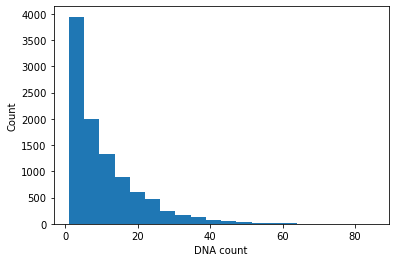

In [20]:
plt.hist(dna_cnt_up, bins=20)
plt.xlabel('DNA count')
plt.ylabel('Count')
plt.show()

Here we arbitrarily choose 5 for the scaling factor. It might be of interest to look more into what number to choose.

In [21]:
df_tr['ct_0'] = dna_cnt_up
df_tr['ct_1'] = df_tr['ct_0'] * df_tr['pbound'] * 5
df_tr['ct_1'] = df_tr['ct_1'].astype(int)
df_tr['ct'] = df_tr['ct_0'] + df_tr['ct_1']

In [22]:
df_tr['ct'] = df_tr['ct'].astype(float)
df_tr['ct_0'] = df_tr['ct_0'].astype(float)
df_tr['ct_1'] = df_tr['ct_1'].astype(float)

In [23]:
df_tr.head()

,seq,pbound,ct_0,ct_1,ct
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.068739,12.0,4.0,16.0
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.022009,4.0,0.0,4.0
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.019749,21.0,2.0,23.0
3,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.013469,6.0,0.0,6.0
4,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.010024,15.0,0.0,15.0


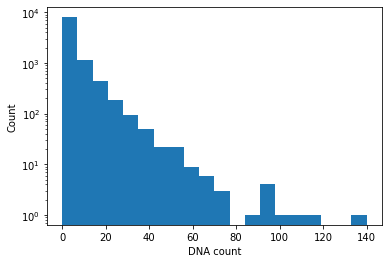

In [24]:
plt.hist(df_tr['ct_1'], bins=20)
plt.xlabel('DNA count')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

Finally we save the data for the next step in the pipeline -- which is to make information footprints!

In [25]:
df_tr.to_csv('../data/synthetic_datasets/lacI_synthetic_dataset.csv', index=False)